In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline
import platform

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))

In [3]:
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()

In [4]:
year = 2019
league = 'BPL'
as_of=pd.to_datetime('2020-01-01')
as_of=None
calib.calibrate_teams(league,year,as_of=as_of)

In [5]:
season = Season(league, year,calib, use_home_advantage=False,as_of=as_of)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)

season.process_simulation()

home advantage 1


In [20]:

ind=None
#i=season.match_id['bpl_liverpool_chelsea_2020-07-22']
#hg=season.simulated_home_goals[i,:]
#ag=season.simulated_away_goals[i,:]
#ind=(hg>=3)&(ag>=1)
#ind=None
#ind = ind&(ag<hg)
# ind= None
#i = season.team_id['Manchester United']
#ind = season.place_per_team[i,:]<=4
#ind = None
sr=season.season_report(ind=ind)
sr

,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,rating,Degr
Liverpool,37,96,98.4,96,99,1,1,100.0,100.00,6.09,0.29,20.717104,0.00
Manchester City,37,78,80.8,79,81,2,2,0.0,100.00,7.21,0.20,36.544512,0.00
Manchester United,37,63,64.7,63,66,5,3,0.0,84.11,4.97,0.23,21.561610,0.00
Chelsea,37,63,64.4,63,66,5,3,0.0,82.05,5.32,0.33,16.195014,0.00
Leicester City,37,62,63.0,62,65,5,3,0.0,33.84,4.31,0.31,14.099025,0.00
Wolverhampton,37,59,60.4,59,62,7,6,0.0,0.00,3.54,0.22,16.156454,0.00
Tottenham Hotspur,37,58,59.8,58,61,7,6,0.0,0.00,3.97,0.33,12.126575,0.00
Burnley,37,54,55.5,54,57,10,8,0.0,0.00,3.23,0.34,9.491389,0.00
Sheffield United,37,54,55.1,54,57,10,8,0.0,0.00,3.03,0.32,9.529895,0.00
Arsenal,37,53,54.7,53,56,10,8,0.0,0.00,3.90,0.32,12.171794,0.00


In [21]:
def f0(season):
    cc=np.linspace(0,1,3)
    clist = np.array([[x,y,z] for x in cc for y in cc for z in cc])
    i=np.round(np.linspace(0,25,20)).astype(int)
    clist=clist[i,:]
    #i
    x=np.arange(season.nr_teams)
    nsim=season.place_per_team.shape[1]
    bottom = np.zeros(season.nr_teams)
    plt.figure(figsize=(16,6))
    jump=1.1
    i_sort = np.argsort(-season.points_per_team.mean(axis=1))
    place_per_team=season.place_per_team[i_sort,:]
    yticks=[]
    ylabels=[]
    c=0
    alpha=1
    for plc in range(int(place_per_team.min()),int(place_per_team.max()+1)):
        probs = (place_per_team==plc).sum(axis=1)/nsim
        plt.bar(x,probs,bottom=bottom,label=plc,color = clist[plc-1,:],edgecolor='black')
        if plc in [4,17]:
            c+=1
            alpha=1
        else:
            alpha = alpha*0.9

        ind = probs>0.01
        if ind.any():
            #print(x[ind],bottom[ind])
            for x_,y_ in zip(x[ind],(bottom+0.1*probs)[ind]):
                plt.text(x_,y_,plc)
        y_=np.linspace(0,1,6)
        yticks+=(jump-1.1+y_).tolist()
        ylabels+=(y_).tolist()
        if plc in []:
            bottom=np.zeros(season.nr_teams)+jump
            jump+=1.1
        else:
            bottom+=probs
    plt.xticks(x,[season.inv_team_id[x] for x in i_sort],rotation=90)
    #plt.yticks(yticks,['{:0.1f}'.format(l) for l in ylabels])
    #plt.legend()
    plt.grid(True)

In [22]:
def f1(season):
    plt.figure(figsize=(4*6,5*6))
    i_sort=np.argsort(-season.points_per_team.mean(axis=1))
    for ii in range(season.nr_teams):
        i_team=i_sort[ii]
        plt.subplot(4,5,ii+1)
        points= season.points_per_team[i_team,:].astype(int)
        place = season.place_per_team[i_team,:].astype(int)

        u_points,i_points=np.unique(points,return_inverse=True)
        u_place,i_place=np.unique(place,return_inverse=True)
        #n/n.sum()
        uPP,i,n=np.unique(np.array([i_points,i_place]),axis=1,return_counts=True,return_inverse=True)
        uPP.T
        #probs = np.zeros()
        probs = np.zeros(uPP.max(axis=1)+1)
        for i in range(uPP.shape[1]):
            i_ = uPP[0,i]
            j_ = uPP[1,i]
            #print(i_,j_)
            probs[i_,j_]=n[i]/points.size
            #plt.text(i_,j_,probs[i_,j_])
            #plt.axvline(x=i_)
            #plt.axhline(y=j_)
        #plt.axvline(x=u_points.size)
        #plt.axhline(y=u_place.size)
        #plt.xticks(np.arange(u_points.size));
        #plt.yticks(np.arange(u_place.size));
        plt.imshow(probs, cmap='binary')
        plt.xticks(np.arange(u_place.size),u_place);
        plt.yticks(np.arange(u_points.size),u_points);
        #plt.xticks(u_place,u_place);
        #plt.yticks(u_points,u_points);
        plt.title(season.inv_team_id[i_team])
        for i in range(probs.shape[0]+1):
            plt.axhline(y=i-0.5)
        for j in range(probs.shape[1]+1):
            plt.axvline(x=j-0.5)
        for i in range(probs.shape[0]):
            for j in range(probs.shape[1]):
                if probs[i,j]>0.01:
                    plt.text(j-0.25,i,'{:0.1f}'.format(100*probs[i,j]),color='red')


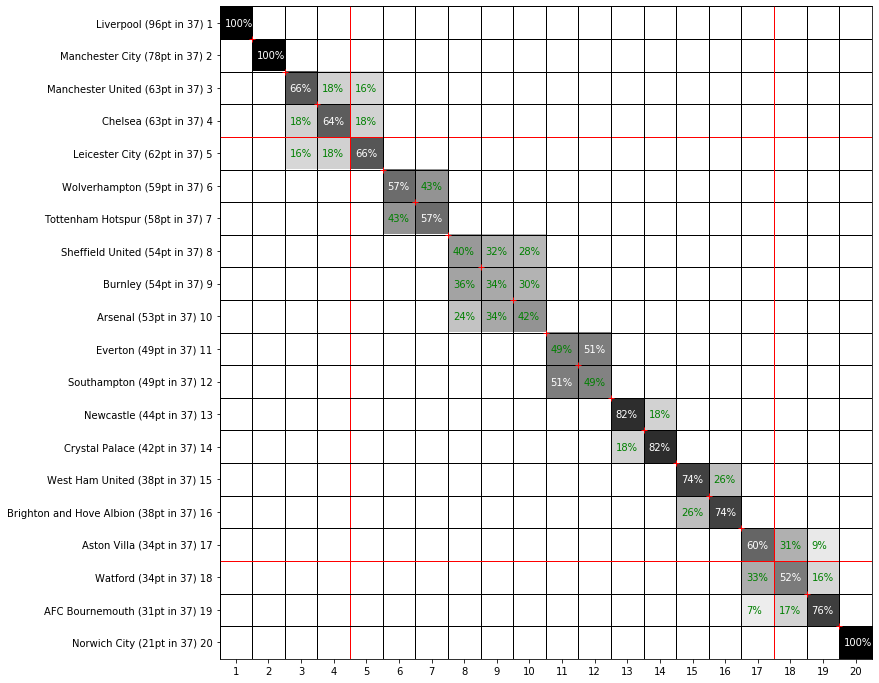

In [23]:
season.probability_grid(ind=ind);

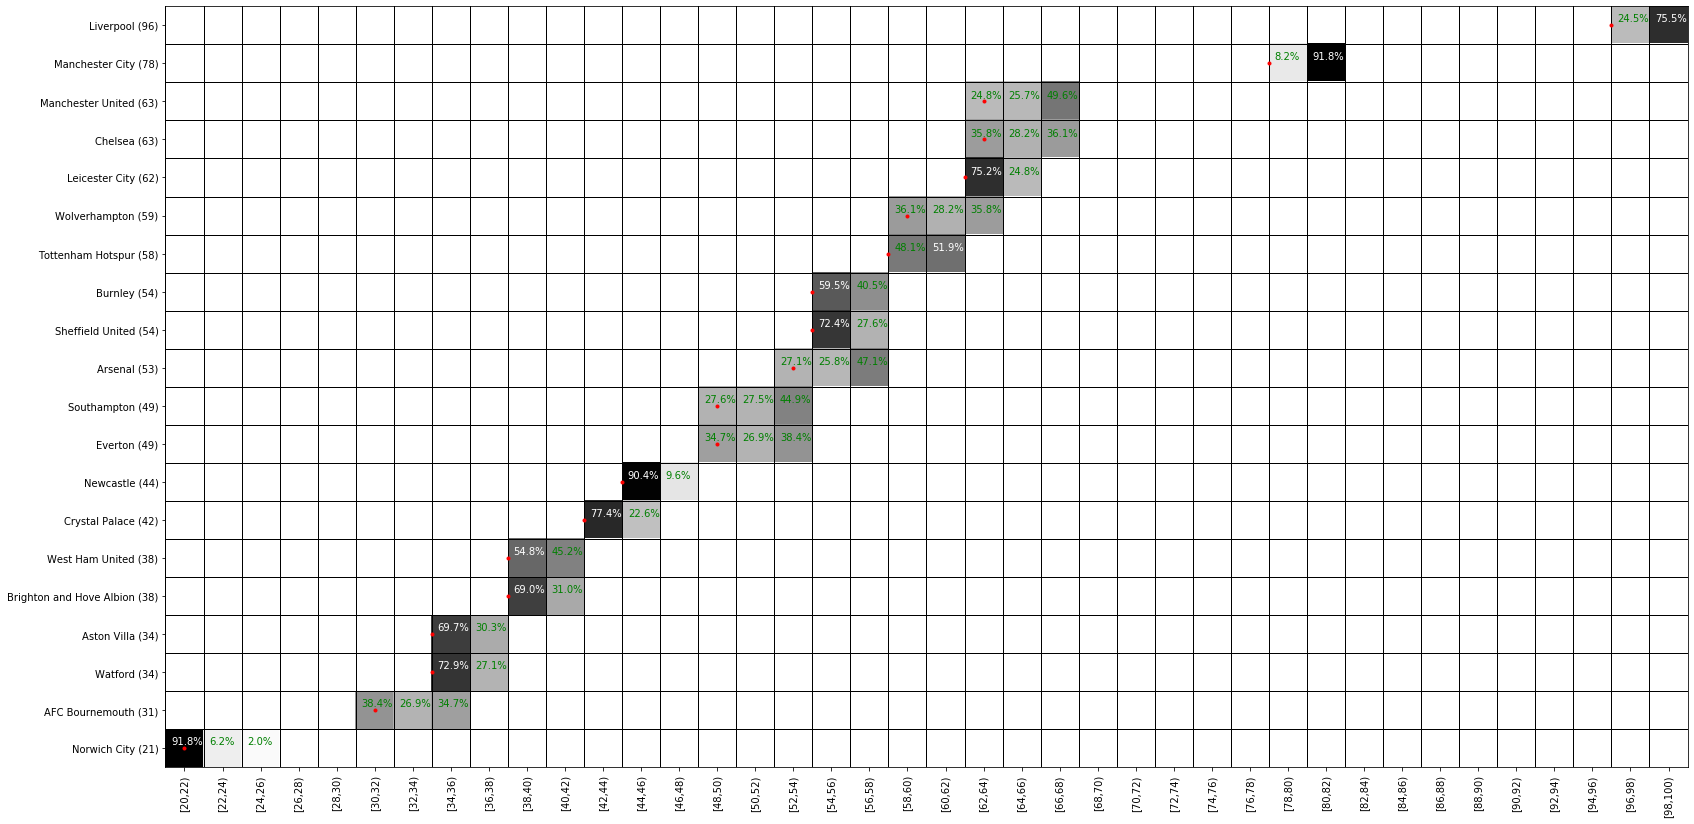

In [24]:
season.points_probability_grid(ind=ind);

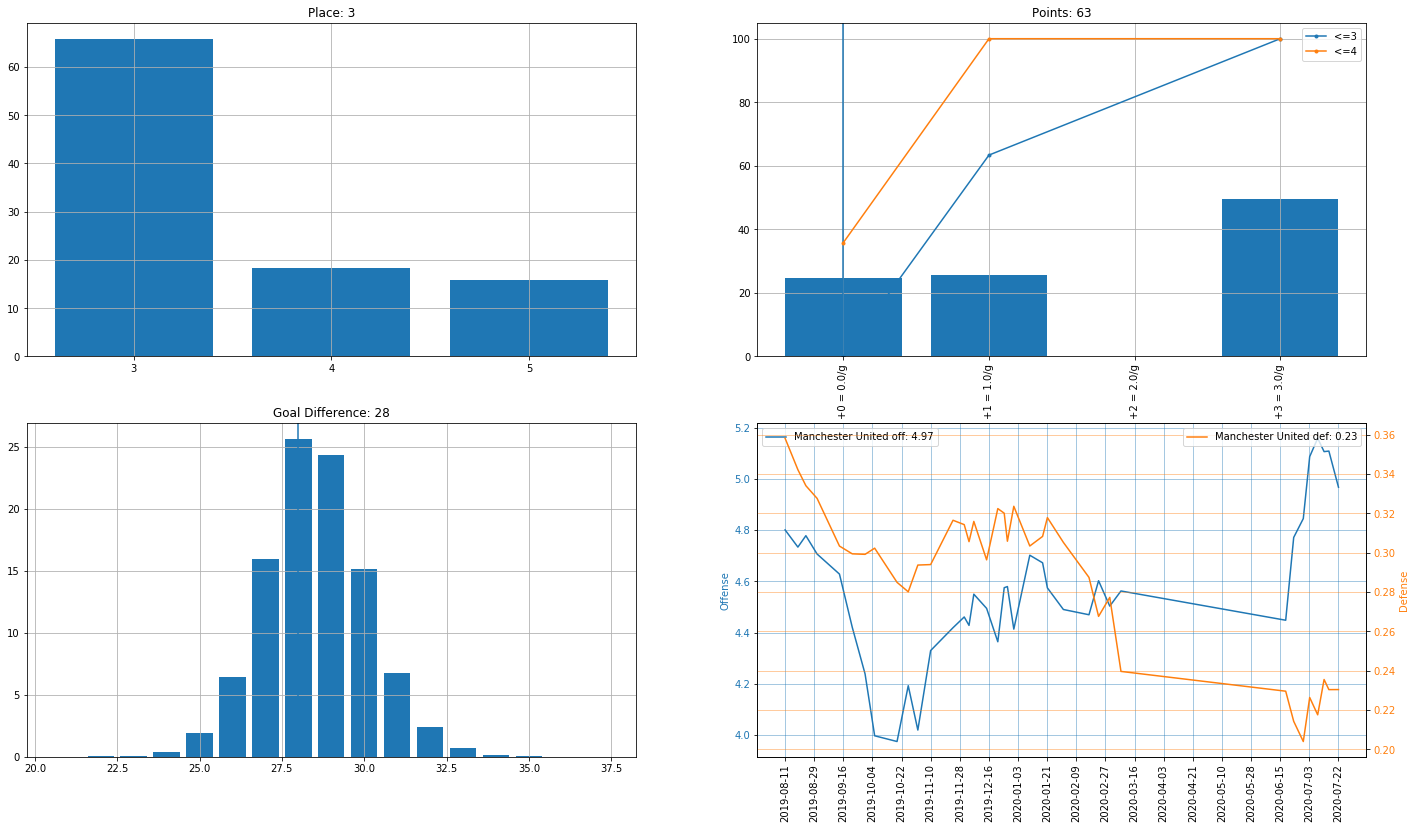

In [25]:
my_team = season.teams['Manchester United']

names = []
importance = []
for m in season.matches_to_sim:
    p=season.what_if(m,ref_team=my_team,place=4,or_better=True,show_plot=False)[0]
    names.append(m.id)
    importance.append(np.sum((p[1:]-p[0])**2))

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
season.team_report(my_team,places=[3,4])


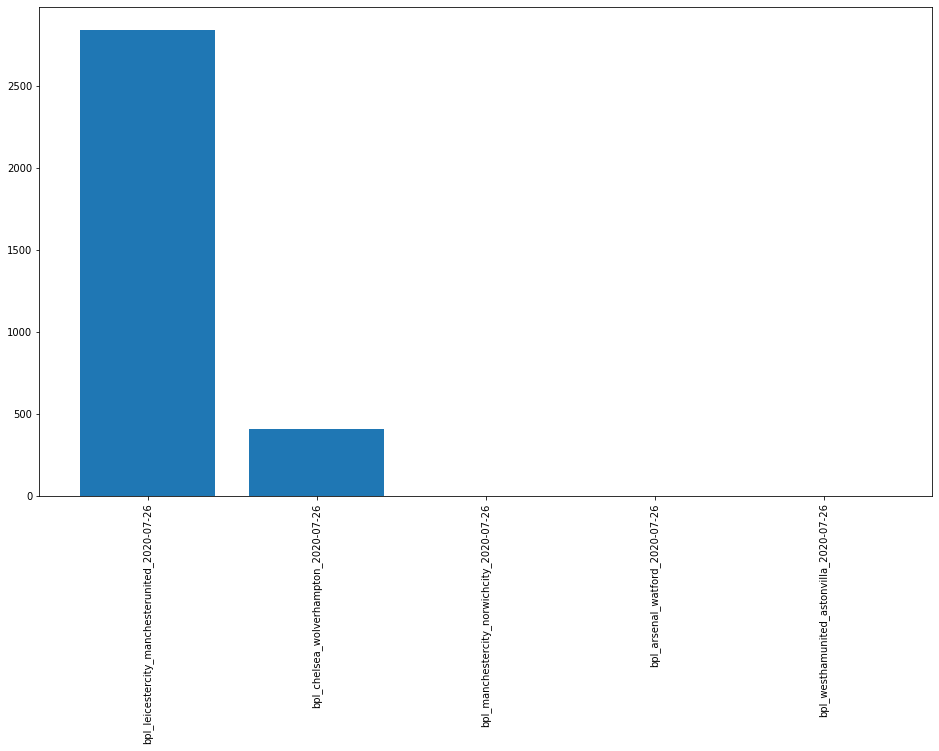

In [26]:
n_plot=5

plt.figure(figsize=(16,9))
plt.bar(np.arange(n_plot),importance[:n_plot])
plt.xticks(np.arange(n_plot),names[:n_plot],rotation=90);

(array([ 84.108     ,  35.81323963, 100.        , 100.        ]),
 <Figure size 1152x648 with 1 Axes>)

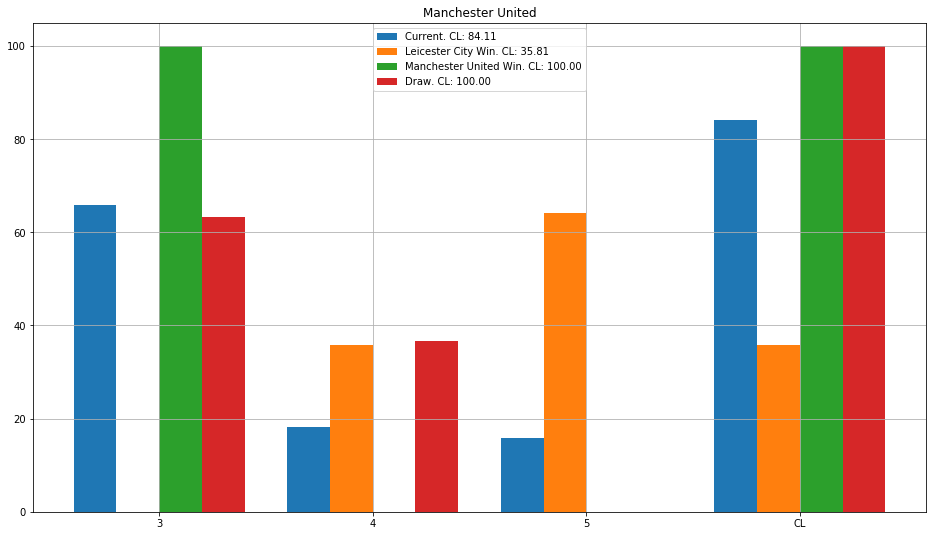

In [28]:
i=season.match_id['bpl_leicestercity_manchesterunited_2020-07-26']
match = season.matches_to_sim[i]
mufc = season.teams['Manchester United']
#wh = season.teams['West Ham United']
season.what_if(match,ref_team=mufc)

In [ ]:
match.home_team.outcomes_vs(match.away_team,g_h=1,t=90-28)

In [ ]:
season.matches_remaining(team_filter=['Manchester U','Leic','Chel'])

In [ ]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


In [14]:
df=pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv')
df=df.set_index('name')
df = df.join(sr).reset_index()[['name','off','def','Off','Deff']].dropna()
df.head(10)

,name,off,def,Off,Deff
0,Manchester City,3.27,0.20,7.21,0.20
2,Liverpool,2.85,0.36,6.09,0.29
6,Manchester United,2.45,0.34,4.97,0.23
9,Chelsea,2.58,0.56,5.32,0.33
13,Wolverhampton,1.94,0.35,3.54,0.22
16,Leicester City,2.15,0.51,4.31,0.31
21,Arsenal,2.08,0.59,3.90,0.32
23,Tottenham Hotspur,2.11,0.66,3.97,0.33
33,Southampton,2.04,0.72,4.20,0.32
34,Everton,1.89,0.62,3.31,0.33


In [ ]:
plt.plot(df['off'],df['Off'],'.')
poly = np.polyfit(df['off'],df['Off'],1)
plt.plot(df['off'],np.polyval(poly,df['off']))
poly

In [ ]:
plt.plot(df['def'],df['Deff'],'.')
poly = np.polyfit(df['def'],df['Deff'],1)
plt.plot(df['def'],np.polyval(poly,df['def']))
poly

In [ ]:
plt.plot(df['off']/df['def'],df['Off']/df['Deff'],'.')